# Building a Vegan Likelihood Model

The goal is to build a model to either predict if a dish is vegan just from the recipe name, or create a scoring model to predict how likely or easily a recipe is or could be vegan.

Or rather, we can take the cosine similarity with a user input for a recipe name and out list of recipes from out database, and then use the top score to get the list of ingredients. Then our model can predict how likely the recipe would be vegan. Could just also list out potentially ingredients that would likely show up as non-vegan in this recipe to watch out for.

## EDA and Pre-processing

In [1]:
import pandas as pd
import ast

In [2]:
df = pd.read_csv('example_recipes.csv')

In [3]:
df.columns

Index(['uri', 'label', 'image', 'source', 'url', 'shareAs', 'yield',
       'dietLabels', 'healthLabels', 'cautions', 'ingredientLines',
       'ingredients', 'calories', 'totalWeight', 'totalTime', 'cuisineType',
       'mealType', 'dishType', 'totalNutrients', 'totalDaily', 'digest',
       'tags'],
      dtype='object')

In [4]:
ingredients_col = df['ingredients'].apply(ast.literal_eval)

In [5]:
ingredients_col[1][0]

{'text': '375g/13oz plain flour',
 'quantity': 375.0,
 'measure': 'gram',
 'food': 'flour',
 'weight': 375.0,
 'foodCategory': 'grains',
 'foodId': 'food_ahebfs0a985an4aubqaebbipra58',
 'image': 'https://www.edamam.com/food-img/b4c/b4c739e76a6f2172b7ad49d0aa41d5aa.jpg'}

In [6]:
dct = dict()
dct.keys()

dict_keys([])

In [7]:
#ingredients_col[1][0]['foodCategory']
dct[ingredients_col[1][0]['foodCategory']] = ingredients_col[1][0]['quantity']

In [8]:
dct = dict()
for i, row in ingredients_col.items():
    for j in range(len(row)):
        key = row[j]['foodCategory']
        value = row[j]['quantity']

        if key in dct.keys():
            dct[key] += value
        else:
            dct[key] = value

In [9]:
'text' in ingredients_col[0][0]

True

In [10]:
dct.keys()

dict_keys(['Eggs', 'Milk', 'Cheese', 'Dairy', 'grains', 'Condiments and sauces', 'condiments and sauces', 'Oils', 'vegetables', 'canned vegetables', 'milk', 'bread, rolls and tortillas', 'cured meats', 'fruit', 'canned grains', 'canned soup', 'bov', 'plant-based protein', 'sugars', 'quick breads and pastries', 'wines', '100% juice', 'water', 'yogurt', 'beer', 'ready-to-eat cereals', 'sugar syrups', 'Cured meats', 'crackers', 'savory snacks', 'liquors and cocktails', 'meats', 'sugar jam', 'Vegan products', 'candy', 'chocolate', None, 'canned fruit', 'non-dairy beverages', 'flavored water', 'cocktails and liquors', 'canned seafood', 'seafood', 'Poultry', 'sweetened beverages', 'pastries', 'frozen treats', 'coffee and tea', 'eggs', 'cooked grains', 'Plant-based protein', 'frozen grained based', 'mixed grains', 'sandwhiches', 'protein and nutritional powders', 'salads'])

In [11]:
ex_s = ''
ex_s_lst = ast.literal_eval(df.iloc[0]['ingredientLines'])
for s in ex_s_lst:
    ex_s += s + ', '

ex_s

'1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil, '

In [12]:
', '.join(ex_s_lst)

'1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil'

## Preprocessing for Transformer

Going to try to preprocess data to take the dish/recipe name (`label` column) and the `healthLabel` as input, and output the ingredients list as a long string. We can use a transformer for this to output the recipe's ingredients in long text form. 

The `healthLabel` will only be a select few options though, and the user can only select 1 for now, from: ['Mediterranean', 'Vegetarian', 'Vegan', 'Red-Meat-Free', 'Paleo', 'Pescatarian']. When reducing the healthLabels column from multilabel to categorical, we need to define a priority order, and if none of these are there then the dish is balanced, so we will add that as an option. In the future, some analysis on this column should be done to improve the priority order, rather than relying on domain knowledge. Alternatively, and option to select multiple could be implemented instead.

In [13]:
priority_order = ['Vegan', 'Vegetarian', 'Pescatarian', 'Paleo', 'Red-Meat-Free', 'Mediterranean']

In [14]:
health_labels = df['healthLabels'].apply(ast.literal_eval)
health_labels

0       [Sugar-Conscious, Low Potassium, Kidney-Friend...
1       [Sugar-Conscious, Low Potassium, Kidney-Friend...
2       [Sugar-Conscious, Low Potassium, Kidney-Friend...
3       [Sugar-Conscious, Low Potassium, Kidney-Friend...
4       [Vegetarian, Pescatarian, Egg-Free, Peanut-Fre...
                              ...                        
1195    [Keto-Friendly, Pescatarian, Mediterranean, Gl...
1196    [Pescatarian, Gluten-Free, Wheat-Free, Egg-Fre...
1197    [Sugar-Conscious, Keto-Friendly, Pescatarian, ...
1198    [Sugar-Conscious, Keto-Friendly, Pescatarian, ...
1199    [Sugar-Conscious, Pescatarian, Mediterranean, ...
Name: healthLabels, Length: 1200, dtype: object

In [15]:
def replace_with_priority(labels):
    for label in priority_order:
        if label in labels:
            return label
    return 'Balanced'  # Handle case where no label matches priority_order, in which case the diet is balanced

# Apply function to the multilabels series
diet_type = health_labels.apply(replace_with_priority)

In [16]:
diet_type.value_counts()

healthLabels
Vegetarian       400
Vegan            279
Pescatarian      209
Balanced         181
Red-Meat-Free     57
Paleo             42
Mediterranean     32
Name: count, dtype: int64

Now we have our dietary preference column. The recipe name is fine as is so next is the ingredients list which is our target variable.

In [17]:
recipe_name = df['label']

We need to just join these lists of strings with commas so they be user friendly to read. 

In [18]:
ingredients_lst = df['ingredientLines'].apply(ast.literal_eval)
ingredients_lst = ingredients_lst.apply(lambda x: ', '.join(x))
ingredients_lst

0       1 organic large egg, 1 teaspoon whole milk or ...
1       375g/13oz plain flour, Pinch salt, 225g/8oz bu...
2       1 cup asiago cheese, grated, 1 cup fontina che...
3       4 ounces, weight Cream Cheese, Softened, 1/2 c...
4       8 ounces elbow pasta, 1/4 cup unsalted butter,...
                              ...                        
1195    4 (6 ounce) tilapia fillets, salt, pepper, 1/2...
1196    * 1 Vegetable oil cooking spray, * 4 U.S.-farm...
1197    2 tbsp chopped red onion, 1 tbsp olive oil, 1 ...
1198    3 tablespoons unsalted butter, 2 tablespoons e...
1199    * 2 tilapia fillets (skinless, about 4 ounces ...
Name: ingredientLines, Length: 1200, dtype: object

Now we can make our dataframe for the modeling.

In [19]:
df2 = pd.concat([diet_type, recipe_name, ingredients_lst], axis = 1)
column_names = {'healthLabels': 'dietType', 'label': 'recipeName', 'ingredientLines': 'ingredientsList'}
df2 = df2.rename(columns=column_names)
df2.head()

,dietType,recipeName,ingredientsList
0,Vegetarian,Cheese Omelette,"1 organic large egg, 1 teaspoon whole milk or ..."
1,Vegetarian,Cheese straws,"375g/13oz plain flour, Pinch salt, 225g/8oz bu..."
2,Vegetarian,CHEESE GOOP,"1 cup asiago cheese, grated, 1 cup fontina che..."
3,Vegetarian,Pimento Cheese,"4 ounces, weight Cream Cheese, Softened, 1/2 c..."
4,Vegetarian,Five Cheese Skillet Mac and Cheese recipes,"8 ounces elbow pasta, 1/4 cup unsalted butter,..."


In [20]:
# models (transformers) can't handle tabular data well so we concatenate input columns
df3 = pd.concat([df2['dietType'] + ' ' + df2['recipeName'], df2['ingredientsList']], axis = 1)
df3 = df3.rename(columns={0: 'recipeTypeName'})
df3.head(3)

,recipeTypeName,ingredientsList
0,Vegetarian Cheese Omelette,"1 organic large egg, 1 teaspoon whole milk or ..."
1,Vegetarian Cheese straws,"375g/13oz plain flour, Pinch salt, 225g/8oz bu..."
2,Vegetarian CHEESE GOOP,"1 cup asiago cheese, grated, 1 cup fontina che..."


In [21]:
df3.to_csv('preprocessed_example_recipes.csv', index=False)

## Modeling

### Gretel

https://colab.research.google.com/github/gretelai/gretel-blueprints/blob/main/docs/notebooks/conditional_text_generation_with_gpt.ipynb#scrollTo=YMg9nX6SczHe

https://gretel.ai/blog/conditional-text-generation-by-fine-tuning-gretel-gpt

In [22]:
from gretel_client import configure_session
from gretel_client.helpers import poll
from gretel_client.projects import create_or_get_unique_project, get_project
from gretel_client.projects.models import read_model_config, Model

In [42]:
LLM = "gretelai/mpt-7b"  # @param {type:"string"}
GRETEL_PROJECT = 'edamam'  # @param {type:"string"}
TEXT_COLUMN = "text"# @param {type:"string"}
LABEL_COLUMN = "ingredientsList" # @param {type:"string"}
LABEL_AND_TEXT_COLUMN = 'recipeTypeName'

In [44]:
config = read_model_config("synthetics/natural-language")
config['models'][0]['gpt_x']['pretrained_model'] = LLM
config['models'][0]['gpt_x']['column_name'] = LABEL_AND_TEXT_COLUMN
config

{'schema_version': '1.0',
 'name': 'natural-language-gpt',
 'models': [{'gpt_x': {'data_source': '__temp__',
    'pretrained_model': 'gretelai/mpt-7b',
    'column_name': 'recipeTypeName',
    'params': {'batch_size': 4,
     'steps': 750,
     'weight_decay': 0.01,
     'warmup_steps': 100,
     'lr_scheduler': 'linear',
     'learning_rate': 0.0002},
    'generate': {'num_records': 80, 'maximum_text_length': 100}}}]}

In [36]:
configure_session(api_key="prompt", cache="yes", endpoint="https://api.gretel.cloud", validate=True, clear=True)

Gretel Api Key ········


Config file C:\Users\RaviB\.gretel\config.json is group- and/or world-readable!
Setting permissions to be readable by the owner only.


Caching Gretel config to disk.
Using endpoint https://api.gretel.cloud
Logged in as ravinderbrai@gmail.com ✅


In [38]:
project = create_or_get_unique_project(name=GRETEL_PROJECT)

In [45]:
model = project.create_model_obj(model_config=config, data_source=df3)
print(f"Follow along with training in the console: {project.get_console_url()}")
model.name = f"{GRETEL_PROJECT}-{LLM}"
model.submit_cloud()

poll(model)

Follow along with training in the console: https://console.gretel.ai/proj_2c86dkC0SVcsijB19WyuyyBDU9L


INFO: Starting poller


{
    "uid": "65c618ccfdff8e43a5ba293a",
    "guid": "model_2c87L94yO3kjdN97XnZcn7bSkK2",
    "model_name": "edamam-gretelai/mpt-7b",
    "model_key": "",
    "runner_mode": "cloud",
    "user_id": "65c58885ece628960a93314c",
    "user_guid": "user_2c6uTY9yUSoUHG8IgV8qYGvL9F6",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "65c61773c22c3df5e1726865",
    "project_guid": "proj_2c86dkC0SVcsijB19WyuyyBDU9L",
    "cluster_guid": null,
    "status_history": {
        "created": "2024-02-09T12:21:32.831198Z"
    },
    "last_modified": "2024-02-09T12:21:32.897097Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "provenance": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/models/gpt_x@sha256:893f53dfe4f500e1f64bf1064c5370a3da5886f70db184bafa300461b8f59820",
    "container_image_version": "2.10.108",
 

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2024-02-09T12:21:54.400419Z  Resolved revision for model
{
    "revision": "4a89ac4fb5c17e714cc27967728b2edd0a401516",
    "model": "gretelai/mpt-7b"
}
2024-02-09T12:21:54.400972Z  Parameter efficient fine tuning (PEFT) methods will be used, which greatly reduce the number of trainable parameters.
2024-02-09T12:21:54.404917Z  Starting GPT model training...
{
    "num_train_steps": 750
}
2024-02-09T12:21:54.405266Z  Fine-tuning 'gretelai/mpt-7b' with provided dataset!
2024-02-09T12:21:54.405503Z  Disclaimer: the chosen model may produce untrue and/or offensive content without warning. For more info, see https://docs.gretel.ai/reference/synthetics/models/gretel-gpt#limitations-and-biases
2024-02-09T12:21:54.405849Z  Downloading model from remote source. Depending on the size of

In [46]:
PROMPT_LABEL = "Vegan Carrot Juice"  # @param {type:"string"}
NUM_RECORDS = 5  # @param {type:"number"}

In [49]:
def create_prompt_df(prompt_label: str, num_records: int = 25) -> pd.DataFrame:
    """
    Create a prompt DataFrame with the given number of rows, each containing a prompt.

    Args:
        prompt_label (str): The class label to use in the prompt.
        num_records (int): The number of records to generate in the prompt DataFrame.
            The generated synthetic data will have the same number of records.

    Returns:
        pd.DataFrame: A DataFrame with the given number of rows, each containing a class
            label prompt.
    """
    # Note: the column name in this dataframe doesn't matter, as it may only contain a single
    # column anyway.
    # The column name in the generated synthetic data will be taken from the training dataset
    # instead.
    return pd.DataFrame([prompt_label] * num_records, columns=["prompt"])


print("Text completion prompts with class labels")
prompt_df = create_prompt_df(PROMPT_LABEL, num_records=NUM_RECORDS)
prompt_df

Text completion prompts with class labels


,prompt
0,Vegan Carrot Juice
1,Vegan Carrot Juice
2,Vegan Carrot Juice
3,Vegan Carrot Juice
4,Vegan Carrot Juice


In [50]:
response_handler = model.create_record_handler_obj(
        params={"maximum_text_length": 100, "temperature": 0.7},
        data_source=prompt_df
    )

In [51]:
response_handler.submit_cloud()
poll(response_handler)

INFO: Starting poller


{
    "uid": "65c61cf766d154ace237a255",
    "guid": "model_run_2c89VDPpveIi7YZFnV4GWbdlH5q",
    "model_name": null,
    "model_key": "",
    "runner_mode": "cloud",
    "user_id": "65c58885ece628960a93314c",
    "user_guid": "user_2c6uTY9yUSoUHG8IgV8qYGvL9F6",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "65c61773c22c3df5e1726865",
    "project_guid": "proj_2c86dkC0SVcsijB19WyuyyBDU9L",
    "cluster_guid": null,
    "status_history": {
        "created": "2024-02-09T12:39:19.717000Z"
    },
    "last_modified": "2024-02-09T12:39:19.861000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "provenance": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/models/gpt_x@sha256:893f53dfe4f500e1f64bf1064c5370a3da5886f70db184bafa300461b8f59820",
    "container_image_version": "2.10.108",
    "model_id": "

INFO: Status is created. A job has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated
INFO: Status is active. A worker has started!
2024-02-09T12:39:34.313771Z  Loading model to worker
2024-02-09T12:39:53.321176Z  Sampling 5 records using conditioning input...
2024-02-09T12:39:53.321711Z  Using device 'cuda'
2024-02-09T12:44:06.108438Z  Generating records...
{
    "num_records": 5
}
2024-02-09T12:44:09.367384Z  Successfully generated 5 records
2024-02-09T12:44:09.398939Z  Uploading artifacts to Gretel Cloud...
2024-02-09T12:44:09.773116Z  Upload to Gretel Cloud is completed.


In [52]:
pd.read_csv(response_handler.get_artifact_link("data"), compression='gzip')

,prompt
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


### Hugging Face

In [73]:
import transformers
import torch
print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.model_selection import train_test_split

Transformers version: 4.24.0
Torch version: 2.0.1


In [74]:
print(torch.cuda.is_available())

False


In [68]:
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
else:
    # If CUDA is not available, fall back to CPU
    device = torch.device('cpu')
    print('GPU is not available. Using CPU.')

GPU is not available. Using CPU.


In [55]:
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

C:\Users\RaviB\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RaviB\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [59]:
inputs = df3['recipeTypeName'].tolist()
outputs = df3['ingredientsList'].tolist()

In [61]:
train_encodings = tokenizer(inputs, return_tensors='pt', padding=True, truncation=True)
train_labels = tokenizer(outputs, return_tensors='pt', padding=True, truncation=True)

In [75]:
# Define training parameters
batch_size = 4
learning_rate = 1e-4
num_epochs = 1

In [63]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [66]:
train_labels

{'input_ids': tensor([[  209,  3648,   508,  ...,     0,     0,     0],
        [    3, 22954,   122,  ...,     0,     0,     0],
        [  209,  4119,     3,  ...,     0,     0,     0],
        ...,
        [  204,     3,    17,  ...,     0,     0,     0],
        [  220, 18396,     7,  ...,     0,     0,     0],
        [ 1429,   204,     3,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [76]:
for epoch in range(num_epochs):
    for i in range(0, len(train_encodings['input_ids']), batch_size):
        inputs = train_encodings['input_ids'][i:i+batch_size]
        labels = train_labels['input_ids'][i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(input_ids=inputs, labels=labels)
        loss = criterion(outputs.logits.view(-1, outputs.logits.shape[-1]), labels.view(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

KeyboardInterrupt: 

### TensorFlow

Adapting this notebook: https://colab.research.google.com/github/snapthat/TF-T5-text-to-text/blob/master/snapthatT5/notebooks/TF-T5-Datasets%20Training.ipynb#scrollTo=dEutWnhiWRAq

In [68]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
from transformers import AutoTokenizer, TFT5ForConditionalGeneration
import datetime
import os
%load_ext tensorboard

tf_version = tf.__version__
print("Tensorflow: ", tf_version)
print("Transformers: ", transformers.__version__)
print("Datasets: ", datasets.__version__)

[]
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tensorflow:  2.13.1
Transformers:  4.34.1
Datasets:  2.12.0


In [69]:
tf_version_split = tf_version.split('.')
assert int(tf_version_split[0])==2 and int(tf_version_split[-2])>=3, f"Tensorflow version should be '2.3+,x', given {tf_version}"

In [70]:
!mkdir data

data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

A subdirectory or file data already exists.


In [110]:
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = len(train_dataset)
nvalid = len(valid_dataset)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}

Total Steps:  270
Total Validation Steps:  30


In [72]:
tokenizer = AutoTokenizer.from_pretrained("t5-base", model_max_length=1024)

In [24]:
dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/RaviB/.cache/huggingface/datasets/csv/default-5a626df6418d8a4d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
#train_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split="train")
#valid_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split='validation')

In [42]:
train_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split="train[:90%]")
valid_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split='train[90%:]')

Found cached dataset csv (C:/Users/RaviB/.cache/huggingface/datasets/csv/default-5a626df6418d8a4d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (C:/Users/RaviB/.cache/huggingface/datasets/csv/default-5a626df6418d8a4d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [48]:
train_dataset.features

{'recipeTypeName': Value(dtype='string', id=None),
 'ingredientsList': Value(dtype='string', id=None)}

In [46]:
data = next(iter(train_dataset))
print("Example data from the dataset: \n", data)

Example data from the dataset: 
 {'recipeTypeName': 'Vegetarian Cheese Omelette', 'ingredientsList': '1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil'}


In [53]:
a = list(['Saint Bernadette Soubirous'])
', '.join([i for i in list(a)])

'Saint Bernadette Soubirous'

In [59]:
s = list(['1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil'])
print(s)
s = ', '.join([i for i in list(s)])
print(s)
f"{s} </s>"

['1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil']
1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil


'1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil </s>'

In [63]:
def encode(example, encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  

    recipe_type_and_name = example['recipeTypeName']
    ingredients = example['ingredientsList']
    
    #context = example['context']
    question_plus = recipe_type_and_name
    answer = list([ingredients])
  
    #question_plus = f"answer_me: {str(question)}"
    question_plus += " </s>"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                               pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                               pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs

In [73]:
train_ds=  train_dataset.map(encode)
valid_ds=  valid_dataset.map(encode)

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

C:\Users\RaviB\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [74]:
ex = next(iter(train_ds))
print("Example data from the mapped dataset: \n", ex)

Example data from the mapped dataset: 
 {'recipeTypeName': 'Vegetarian Cheese Omelette', 'ingredientsList': '1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil', 'input_ids': [3901, 2782, 6855, 21060, 13285, 15, 15529, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [75]:
def to_tf_dataset(dataset):  
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds

In [76]:
tf_train_ds = to_tf_dataset(train_ds)
tf_valid_ds = to_tf_dataset(valid_ds)

In [77]:
def create_dataset(dataset, cache_path=None, batch_size=4, 
                   buffer_size= 1000, shuffling=True):    
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [78]:
tf_train_ds= create_dataset(tf_train_ds, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size, 
                         shuffling=False, cache_path = None)

In [79]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=1e4):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)
    
    return lr 

Text(0, 0.5, 'Learning rate')

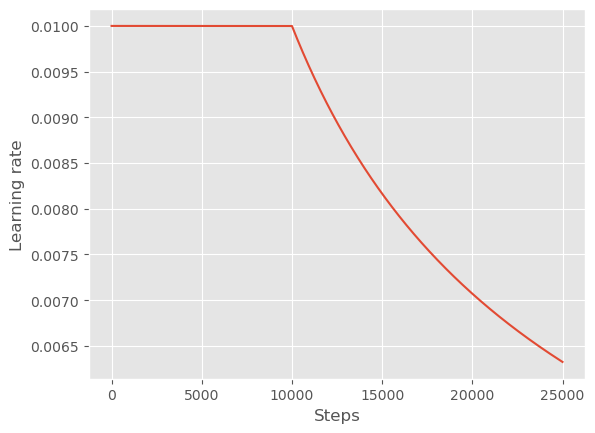

In [80]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype=tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

In [111]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

In [112]:
#learning_rate = CustomSchedule()
learning_rate = 0.001  # Instead set a static learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)

In [113]:
model = SnapthatT5.from_pretrained("t5-base")

All PyTorch model weights were used when initializing SnapthatT5.

Some weights or buffers of the TF 2.0 model SnapthatT5 were not initialized from the PyTorch model and are newly initialized: ['total', 'count']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
model.compile(optimizer=optimizer, metrics=metrics)

In [115]:
#%tensorboard --logdir ./data/experiments/t5/logs

In [116]:
epochs_done = 0
model.fit(tf_train_ds, epochs=2, validation_data=tf_valid_ds)

Epoch 1/2
     74/Unknown - 378s 5s/step - accuracy: 0.6969 - loss: 2.7471 - lr: 0.0010

KeyboardInterrupt: 

### PyTorch

Trying the above with pytorch since TensorFlow doesn't support windows when using GPUs anymore. Following along with https://huggingface.co/docs/transformers/tasks/question_answering to make sure it works.

In [1]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use GPU.")
    # Additional information
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))  # 0 is the GPU index
else:
    print("CUDA is not available. PyTorch will use CPU.")


CUDA is available! PyTorch can use GPU.
Number of CUDA devices: 1
CUDA device name: NVIDIA GeForce RTX 3060


In [24]:
dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv')

Downloading:   0%|          | 0.00/887 [00:00<?, ?B/s]

Using custom data configuration default


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\RaviB\.cache\huggingface\datasets\csv\default-b6a663c53062697f\0.0.0\0d06ce3712951dae7909fb214283b88efab3578535edb5eebd37c498b7a35277. Subsequent calls will reuse this data.


In [2]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)
#train_dataset = load_dataset('squad', split='train')
#valid_dataset = load_dataset('squad', split='validation')

Reusing dataset squad (C:\Users\RaviB\.cache\huggingface\datasets\squad\plain_text\1.0.0\1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41)


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\RaviB\\.cache\\huggingface\\datasets\\squad\\plain_text\\1.0.0\\1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41\\tmp_nf3mnxj'

In [56]:
tokenizer = AutoTokenizer.from_pretrained("t5-base", model_max_length=1024)

In [59]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [67]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)

AttributeError: module 'dill._dill' has no attribute 'PY3'

In [28]:
tokenizer = AutoTokenizer.from_pretrained("t5-base", model_max_length=1024)

In [31]:
def preprocess_data(example):
    passage = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]

    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"
    
    input_text = f"question: {question} context: {passage}"

    
    target_text = answer

    
    return tokenizer(input_text, padding="max_length", truncation=True), tokenizer(target_text, padding="max_length", truncation=True)

In [46]:
import numpy as np
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = len(train_dataset)
nvalid = len(valid_dataset)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  
    context = example['context']
    question = example['question']
    answer = example['answers']['text']
  
    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)} </s>"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs

Total Steps:  21900
Total Validation Steps:  2643


In [40]:
#squad["train"]['answers']

In [47]:
train_ds=  train_dataset.map(encode)
valid_ds=  valid_dataset.map(encode)

C:\Users\RaviB\anaconda3\envs\edamam\Lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AttributeError: module 'dill._dill' has no attribute 'PY3'